In [ ]:
import pandas as pd

raw_df = pd.read_csv("combine_muts_1pos.csv", index_col=0)
raw_df

In [3]:
data_path = "/data/lujd/neoag_data/"
hla_seq_dict = pd.read_csv(
    data_path+"main_task/HLA_sequence_dict_ABCEG.csv",
    index_col=0
    ).set_index(["HLA_name"])["clip"].to_dict()
our_hla_list = hla_seq_dict.keys()
df = raw_df[raw_df["HLA"].isin(our_hla_list)]
df

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,YTDFPCQYV,YTDFHCQYV,HLA-A*01:01
3,YTDFPCQYVK,YTDFHCQYVK,HLA-A*01:01
4,FSADISFFF,FSADIFFFF,HLA-A*01:01
...,...,...,...
192,VLRDDLLEA,VLHDDLLEA,HLA-A*02:01
193,EEKRGSLYVW,EEKRGSLHVW,HLA-B*44:03
194,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
195,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [4]:
hlas = df.HLA.to_list()
wild_peps = df.wild_type.to_list()
mut_peps = df.mut_type.to_list()
mut_poss = []
for ind, wild_pep in enumerate(wild_peps):
    mut_num = 0
    for index, mut_amino in enumerate(mut_peps[ind]):
        if wild_pep[index] != mut_amino:
            mut_num += 1
            mut_poss.append(index+1)
    print(f"{hlas[ind]} {wild_pep}\tmut_num={mut_num}\t{mut_poss[ind]}")

HLA-A*01:01 PFDTRQMLFY	mut_num=1	2
HLA-A*01:01 LTDDRLFTCH	mut_num=1	10
HLA-A*01:01 YTDFPCQYV	mut_num=1	5
HLA-A*01:01 YTDFPCQYVK	mut_num=1	5
HLA-A*01:01 FSADISFFF	mut_num=1	6
HLA-A*01:01 HTQGLSPGCY	mut_num=1	8
HLA-A*01:01 LPPTLNPIVY	mut_num=1	2
HLA-A*01:01 ISGHRSVSWY	mut_num=1	8
HLA-A*01:01 EVDPIGHVY	mut_num=1	1
HLA-A*02:01 YMNGTMSQV	mut_num=1	3
HLA-A*02:01 CLNEYHLFF	mut_num=1	9
HLA-A*02:01 FLYNPLTRV	mut_num=1	5
HLA-A*02:01 IILVAVQHV	mut_num=1	7
HLA-A*02:01 EMIGNHLWV	mut_num=1	1
HLA-A*02:01 AMFRSVPTV	mut_num=1	4
HLA-A*02:01 KLMNIQQQL	mut_num=1	8
HLA-A*02:01 QLSCTSTYV	mut_num=1	5
HLA-A*02:01 HPYASLSRV	mut_num=1	2
HLA-A*02:01 MLGERLFPL	mut_num=1	5
HLA-A*02:01 VLLGVKLSGV	mut_num=1	8
HLA-A*02:01 TPWCSPIKV	mut_num=1	2
HLA-A*02:01 GPLDEDFYA	mut_num=1	2
HLA-A*02:01 KPILWRGLK	mut_num=1	2
HLA-A*02:01 ALQSRRQAL	mut_num=1	6
HLA-A*02:01 KVWCCQILL	mut_num=1	3
HLA-A*02:01 ALIHHNTHL	mut_num=1	8
HLA-A*02:01 VLENFTILLV	mut_num=1	8
HLA-A*02:01 ILTGLNYEA	mut_num=1	9
HLA-A*02:01 FLTYLDVSV	mut_num=1	3
HLA-A

In [5]:
import sys 
if ".." not in sys.path:
    sys.path.append("..")

import torch
from tape import TAPETokenizer, ProteinBertConfig
from model_ft import meanTAPE

# prepare model
use_cuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
model_path = "/data/lujd/neoag_model/main_task/TAPE_ft/cat_mean_2mlp/"
model_name = "main_finetune_plm_tape_B32_LR3e-05_seq_clip_fold4_ep51_221104.pkl"

print("Model preparing")
tokenizer = TAPETokenizer(vocab='iupac')
tape_config = ProteinBertConfig.from_pretrained('bert-base')
model = meanTAPE(tape_config, "2mlp").to(device)
model.load_state_dict(torch.load(model_path + model_name, map_location=device), strict = True)
print("Model preparing done")

Model preparing
Model preparing done


In [8]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=1, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
Iteration-1, mutant_pool size: 19
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCY | 10 H->Y | binding probability: 0.9997
--- 1	HLA-A*01:01,LTDDRLFTCH	| output:['LTDDRLFTCY'], given:LTDDRLFTCY	| 1 1

given HLA: HLA-A*01:01, given peptide: YTDFPCQYV | binding porbability: 1.0000
Iteration-1, mutant_pool size: 19
source peptide: YTDFPCQYV, mutated peptide: YTDFPSQYV | 6 C->S | binding probability: 1.0000
--- 2	HLA-A*01:01,YTDFPCQYV	| output:['YTDFPSQYV'], given:YTDFHCQYV	| 0 0

given HLA: HLA-A*01:01, given peptide: YTDFPCQYVK | binding porbability: 0.9996
Iteration-1, mutant_pool size: 19
source peptide: YTDFPCQYVK, mu

In [10]:
hit_num, hit_pos_num

(14, 52)

In [11]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=3, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
Iteration-1, mutant_pool size: 19
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCW | 10 H->W | binding probability: 0.9996
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCF | 10 H->F | binding probability: 0.9996
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCY | 10 H->Y | binding probability: 0.9997
--- 1	HLA-A*01:01,LTDDRLFTCH	| output:['LTDDRLFTCW', 'LTDDRLFTCF', 'LTDDRLFTCY'], given:LTDDR

In [12]:
hit_num, hit_pos_num

(26, 52)

In [13]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
Iteration-1, mutant_pool size: 19
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCL | 10 H->L | binding probability: 0.9819
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCM | 10 H->M |

In [14]:
hit_num, hit_pos_num

(32, 52)

In [15]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=10, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: VFDTRQMLFY | 1 P->V | binding probability: 0.9846
source peptide: PFDTRQMLFY, mutated peptide: IFDTRQMLFY | 1 P->I | binding probability: 0.9902
source peptide: PFDTRQMLFY, mutated peptide: HFDTRQMLFY | 1 P->H | binding probability: 0.9908
source peptide: PFDTRQMLFY, mutated peptide: LFDTRQMLFY | 1 P->L | binding probability: 0.9910
source peptide: PFDTRQMLFY, mutated peptide: EFDTRQMLFY | 1 P->E | binding probability: 0.9940
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mut

In [16]:
hit_num, hit_pos_num

(40, 52)

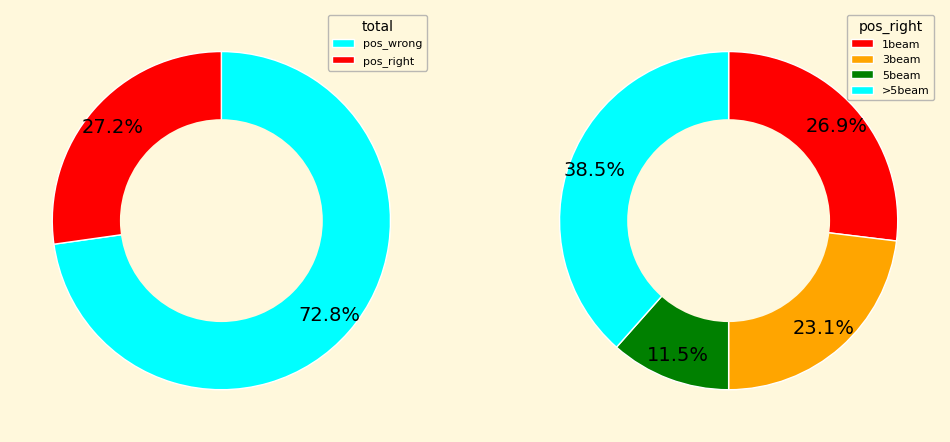

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
# 配置字体，显示中文
mpl.rcParams['font.sans-serif'] = ['SimHei']  
# 配置坐标轴刻度值模式，显示负号
mpl.rcParams['axes.unicode_minus'] = False

# 定义数据
element1 = ['pos_wrong', 'pos_right']
weight1 = [191-52, 52]
cs1 = ['cyan','red']

element2 = ['1beam', '3beam', '5beam', '>5beam']
weight2 = [14, 26-14, 32-26, 52-32]
cs2 = ['red', 'orange', 'green', 'cyan']

# 初始化图表区
fig = plt.figure(figsize=(12, 8), facecolor='cornsilk')

plt.subplot(121)
# 绘制外层圆环
wedges1, texts1, autotexts1 = plt.pie(x=weight1,
                                      autopct='%3.1f%%',
                                      radius=1,
                                      pctdistance=0.85,
                                      startangle=90,
                                      counterclock=False,
                                      colors=cs1,
                                      # 锲形块边界属性字典
                                      wedgeprops={'edgecolor': 'white',
                                                  'linewidth': 1,
                                                  'linestyle': '-'
                                                  },
                                      # 锲形块标签文本和数据标注文本的字体属性
                                      textprops=dict(color='k',  #  字体颜色
                                                     fontsize=14,
                                                     family='Arial'               
                                                     )
                                     )

# 绘制中心空白区域
plt.pie(x=[1],
        radius=0.6,
        colors=[fig.get_facecolor()]
       )

# 设置图例
plt.legend(handles=wedges1,
           loc='best',
           labels=element1,
           title='total',
           facecolor = fig.get_facecolor(),    # 图例框的填充颜色
           edgecolor='darkgray',
           fontsize=8 
          )

plt.subplot(122)
# 绘制外层圆环
wedges2, texts2, autotexts2 = plt.pie(x=weight2,
                                      autopct='%3.1f%%',
                                      radius=1,
                                      pctdistance=0.85,
                                      startangle=90,
                                      counterclock=False,
                                      colors=cs2,
                                      # 锲形块边界属性字典
                                      wedgeprops={'edgecolor': 'white',
                                                  'linewidth': 1,
                                                  'linestyle': '-'
                                                  },
                                      # 锲形块标签文本和数据标注文本的字体属性
                                      textprops=dict(color='k',  #  字体颜色
                                                     fontsize=14,
                                                     family='Arial'               
                                                     )
                                     )

# 绘制中心空白区域
plt.pie(x=[1],
        radius=0.6,
        colors=[fig.get_facecolor()]
       )

# 设置图例
plt.legend(handles=wedges2,
           loc='best',
           labels=element2,
           title='pos_right',
           facecolor = fig.get_facecolor(),    # 图例框的填充颜色
           edgecolor='darkgray',
           fontsize=8
          )

----
non-binding predicted by our model

In [11]:
from mutation_release import get_mutated_peptides

neg_num = 0
hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=0.5,
                                                  writein_file=False, algorithm="2a")
    if len(output_pep) > 0:
        neg_num += 1
        if given_mut in output_pep:
            is_hitten = 1
            hit_num += 1
        else:
            is_hitten = 0

        if given_pos in output_pos:
            pos_is_hitten = 1
            hit_pos_num += 1
        else:
            pos_is_hitten = 0
        print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
No need to mutate
given HLA: HLA-A*01:01, given peptide: YTDFPCQYV | binding porbability: 1.0000
No need to mutate
given HLA: HLA-A*01:01, given peptide: YTDFPCQYVK | binding porbability: 0.9996
No

In [8]:
neg_num, hit_pos_num, hit_num

(49, 22, 9)

In [10]:
neg_num, hit_pos_num, hit_num

(49, 22, 14)

In [12]:
neg_num, hit_pos_num, hit_num

(49, 22, 17)

([<matplotlib.axis.XTick at 0x7f5ab25d81c0>,
 [Text(0, 0, 'Top1'),
  Text(1, 0, 'Top3'),
  Text(2, 0, 'Top5'),
  Text(3, 0, 'Position')])

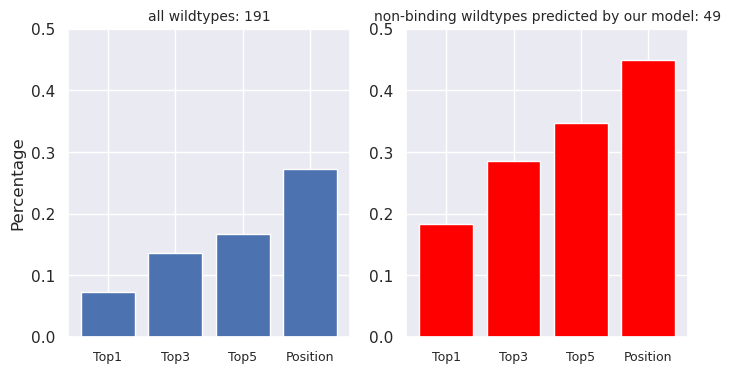

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

cell = ['Top1','Top3','Top5','Position']
index = np.arange(len(cell)) 

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
total1 = 191
x1 = np.asarray([14, 26, 32, 52])
plt.bar(index, x1/total1)
ax1.set_title(f"all wildtypes: {total1}", fontsize=10)
plt.ylabel("Percentage")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

ax2 = plt.subplot(122)
total2 = 49
x2 = np.asarray([9, 14, 17, 22])
plt.bar(index, x2/total2, color="red")
ax2.set_title(f"non-binding wildtypes predicted by our model: {total2}", fontsize=10)
plt.ylabel("Percentage")
plt.ylabel("")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

# fig.suptitle("Model-2 over Model-1 on HLA-Bs",fontsize=15,x=0.49,y=1.02)

----

In [47]:
import pandas as pd

raw_df = pd.read_csv("combine_muts_1pos_2.csv", index_col=0)
raw_df

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01
...,...,...,...
149,DANPFLQSV,DANSFLQSV,HLA-B*51:01
150,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01
151,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
152,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [60]:
data_path = "/data/lujd/neoag_data/"
hla_seq_dict = pd.read_csv(
    data_path+"main_task/HLA_sequence_dict_ABCEG.csv",
    index_col=0
    ).set_index(["HLA_name"])["clip"].to_dict()
our_hla_list = hla_seq_dict.keys()
df = raw_df[raw_df["HLA"].isin(our_hla_list)].reset_index(drop=True)
df

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01
...,...,...,...
140,DANPFLQSV,DANSFLQSV,HLA-B*51:01
141,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01
142,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
143,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [61]:
def diff(x, y):
    cnt = 0
    for i in range(len(x)):
        if x[i] != y[i]:
            return i+1

df['mut_pos'] = df.apply(lambda x: diff(x['wild_type'], x['mut_type']), axis=1)
df

,wild_type,mut_type,HLA,mut_pos
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01,2
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01,10
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01,8
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01,2
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01,8
...,...,...,...,...
140,DANPFLQSV,DANSFLQSV,HLA-B*51:01,4
141,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01,8
142,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02,3
143,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01,7


In [62]:
hlas = df.HLA.to_list()
wild_peps = df.wild_type.to_list()
mut_peps = df.mut_type.to_list()
mut_poss = df.mut_pos.to_list()

In [64]:
mut_peps[38], wild_peps[38], mut_poss[38]

('KLYGLDWAEL', 'KPYGLDWAEL', 2)

In [40]:
import sys 
if ".." not in sys.path:
    sys.path.append("..")

import torch
from tape import TAPETokenizer, ProteinBertConfig
from model_ft import meanTAPE

# prepare model
use_cuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
model_path = "/data/lujd/neoag_model/main_task/TAPE_ft/cat_mean_2mlp/"
model_name = "main_finetune_plm_tape_B32_LR3e-05_seq_clip_fold4_ep51_221104.pkl"

print("Model preparing")
tokenizer = TAPETokenizer(vocab='iupac')
tape_config = ProteinBertConfig.from_pretrained('bert-base')
model = meanTAPE(tape_config, "2mlp").to(device)
model.load_state_dict(torch.load(model_path + model_name, map_location=device), strict = True)
print("Model preparing done")

Model preparing
Model preparing done


In [69]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
Iteration-1, mutant_pool size: 19
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCL | 10 H->L | binding probability: 0.9819
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCM | 10 H->M |

In [70]:
hit_num, hit_pos_num

(29, 46)

In [77]:
from mutation_release import get_mutated_peptides

neg_num = 0
hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=0.5,
                                                  writein_file=False, algorithm="2a")
    if len(output_pep) > 0:
        neg_num += 1
        if given_mut in output_pep:
            is_hitten = 1
            hit_num += 1
        else:
            is_hitten = 0

        if given_pos in output_pos:
            pos_is_hitten = 1
            hit_pos_num += 1
        else:
            pos_is_hitten = 0
        print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
No need to mutate
given HLA: HLA-A*01:01, given peptide: HTQGLSPGCY | binding porbability: 0.9933
No need to mutate
given HLA: HLA-A*01:01, given peptide: LPPTLNPIVY | binding porbability: 0.9930
N

In [78]:
neg_num, hit_pos_num, hit_num

(42, 19, 16)

([<matplotlib.axis.XTick at 0x7f5ab23ae160>,
 [Text(0, 0, 'Top1'),
  Text(1, 0, 'Top3'),
  Text(2, 0, 'Top5'),
  Text(3, 0, 'Position')])

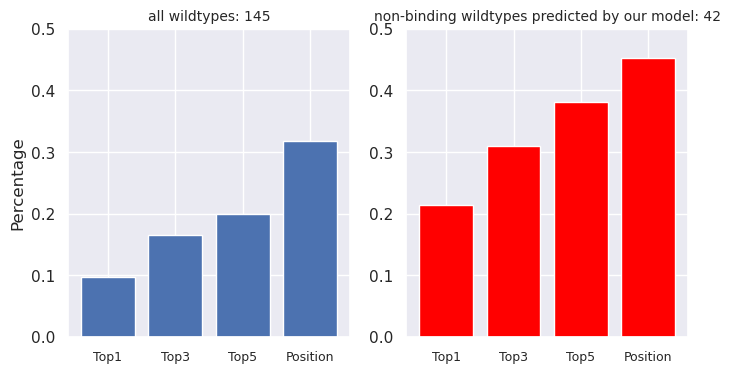

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

cell = ['Top1','Top3','Top5','Position']
index = np.arange(len(cell)) 

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
total1 = 145
x1 = np.asarray([14, 24, 29, 46])
plt.bar(index, x1/total1)
ax1.set_title(f"all wildtypes: {total1}", fontsize=10)
plt.ylabel("Percentage")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

ax2 = plt.subplot(122)
total2 = 42
x2 = np.asarray([9, 13, 16, 19])
plt.bar(index, x2/total2, color="red")
ax2.set_title(f"non-binding wildtypes predicted by our model: {total2}", fontsize=10)
plt.ylabel("Percentage")
plt.ylabel("")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

# fig.suptitle("Model-2 over Model-1 on HLA-Bs",fontsize=15,x=0.49,y=1.02)

---

In [4]:
import pandas as pd

raw_df = pd.read_csv("combine_muts_1pos_2.csv", index_col=0)
exp_hla = list(raw_df.HLA.unique())
exp_hla, len(exp_hla)

(['HLA-A*01:01',
  'HLA-A*02:01',
  'HLA-A*02:01 ',
  'HLA-A*02:05',
  'HLA-A*03:01',
  'HLA-A*11:01',
  'HLA-A*23:01',
  'HLA-A*24:02',
  'HLA-A*30:02',
  'HLA-A*31:01',
  'HLA-A*32:01',
  'HLA-A*33:03',
  'HLA-B*07:02',
  'HLA-B*08:01',
  'HLA-B*15:01',
  'HLA-B*15:17',
  'HLA-B*18:01',
  'HLA-B*35:01',
  'HLA-B*38:01',
  'HLA-B*44:02',
  'HLA-C*03',
  'HLA-C*03:04',
  'HLA-C*05:01',
  'HLA-C*07:01',
  'HLA-C*14:02',
  'HLA-C*14:03',
  'HLA-A*68:01',
  'HLA-B*44:03',
  'HLA-A*68:02',
  'HLA-B*52:01',
  'HLA-B*27:05',
  'HLA-B*51:01'],
 32)

In [6]:
data_path = "/data/lujd/neoag_data/main_task/"
hla_seq_df = pd.read_csv(data_path+"HLA_sequence_dict_ABCEG.csv", index_col=0)
train_hla_list = hla_seq_df["HLA_name"].to_list()[:112]
new_hla_list = hla_seq_df["HLA_name"].to_list()[112:]

In [7]:
set(exp_hla)&set(train_hla_list)

{'HLA-A*01:01',
 'HLA-A*02:01',
 'HLA-A*02:05',
 'HLA-A*03:01',
 'HLA-A*11:01',
 'HLA-A*23:01',
 'HLA-A*24:02',
 'HLA-A*30:02',
 'HLA-A*31:01',
 'HLA-A*32:01',
 'HLA-A*68:01',
 'HLA-A*68:02',
 'HLA-B*07:02',
 'HLA-B*08:01',
 'HLA-B*15:01',
 'HLA-B*15:17',
 'HLA-B*18:01',
 'HLA-B*27:05',
 'HLA-B*35:01',
 'HLA-B*38:01',
 'HLA-B*44:02',
 'HLA-B*44:03',
 'HLA-B*51:01',
 'HLA-B*52:01',
 'HLA-C*03:04',
 'HLA-C*05:01',
 'HLA-C*07:01',
 'HLA-C*14:02'}

In [8]:
set(exp_hla)&set(new_hla_list)

{'HLA-A*33:03', 'HLA-C*14:03'}

In [9]:
raw_df[raw_df.HLA.isin(train_hla_list)]

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01
...,...,...,...
149,DANPFLQSV,DANSFLQSV,HLA-B*51:01
150,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01
151,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
152,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [10]:
raw_df[raw_df.HLA.isin(new_hla_list)]

,wild_type,mut_type,HLA
74,EYFMKQMNDAH,EYFMKQMNDAR,HLA-A*33:03
75,HVKITDFGL,HVKITDFGR,HLA-A*33:03
106,CYMEALAL,CYMEAVAL,HLA-C*14:03
107,CYMEALALV,CYMEAVALV,HLA-C*14:03


In [11]:
df = raw_df[raw_df.HLA.isin(new_hla_list)]

In [12]:
def diff(x, y):
    cnt = 0
    for i in range(len(x)):
        if x[i] != y[i]:
            return i+1

df['mut_pos'] = df.apply(lambda x: diff(x['wild_type'], x['mut_type']), axis=1)
df

/tmp/ipykernel_584781/374812252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mut_pos'] = df.apply(lambda x: diff(x['wild_type'], x['mut_type']), axis=1)


,wild_type,mut_type,HLA,mut_pos
74,EYFMKQMNDAH,EYFMKQMNDAR,HLA-A*33:03,11
75,HVKITDFGL,HVKITDFGR,HLA-A*33:03,9
106,CYMEALAL,CYMEAVAL,HLA-C*14:03,6
107,CYMEALALV,CYMEAVALV,HLA-C*14:03,6


In [13]:
hlas = df.HLA.to_list()
wild_peps = df.wild_type.to_list()
mut_peps = df.mut_type.to_list()
mut_poss = df.mut_pos.to_list()

In [14]:
import sys 
if ".." not in sys.path:
    sys.path.append("..")

import torch
from tape import TAPETokenizer, ProteinBertConfig
from model_ft import meanTAPE

# prepare model
use_cuda = True
device = torch.device("cuda:7" if (torch.cuda.is_available() and use_cuda) else "cpu")
model_path = "/data/lujd/neoag_model/main_task/TAPE_ft/cat_mean_2mlp/"
model_name = "main_finetune_plm_tape_B32_LR3e-05_seq_clip_fold4_ep51_221104.pkl"

print("Model preparing")
tokenizer = TAPETokenizer(vocab='iupac')
tape_config = ProteinBertConfig.from_pretrained('bert-base')
model = meanTAPE(tape_config, "2mlp").to(device)
model.load_state_dict(torch.load(model_path + model_name, map_location=device), strict = True)
print("Model preparing done")

Model preparing
Model preparing done


In [15]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*33:03, given peptide: EYFMKQMNDAH | binding porbability: 0.0000
Iteration-1, mutant_pool size: 19
source peptide: EYFMKQMNDAH, mutated peptide: EYFMKCMNDAH | 6 Q->C | binding probability: 0.0003
source peptide: EYFMKQMNDAH, mutated peptide: EYFMKWMNDAH | 6 Q->W | binding probability: 0.0013
source peptide: EYFMKQMNDAH, mutated peptide: EYFMKHMNDAH | 6 Q->H | binding probability: 0.0023
source peptide: EYFMKQMNDAH, mutated peptide: EYFMKYMNDAH | 6 Q->Y | binding probability: 0.0100
source peptide: EYFMKQMNDAH, mutated peptide: EYFMKFMNDAH | 6 Q->F | binding probability: 0.2202
--- 0	HLA-A*33:03,EYFMKQMNDAH	| output:['EYFMKCMNDAH', 'EYFMKWMNDAH', 'EYFMKHMNDAH', 'EYFMKYMNDAH', 'EYFMKFMNDAH'], given:EYFMKQMNDAR	| 0 0

given HLA: HLA-A*33:03, given peptide: HVKITDFGL | binding porbability: 0.0000
Iteration-1, mutant_pool size: 19
source peptide: HVKITDFGL, mutated peptide: HVKILDFGL | 5 T->L | binding probability: 0.0019
source peptide: HVKITDFGL, mutated peptide: HVKIWDFGL